youtube 이수안 컴퓨터
XGBoost, LightGBM

In [4]:
import pandas as pd
import numpy as np
#from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score,recall_score

import xgboost as xgb
from xgboost import XGBRFClassifier,XGBRFRegressor
from xgboost import plot_importance, plot_tree

import graphviz
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])


In [5]:
df=pd.read_csv('final_fire_weather_7yr.csv')

In [6]:
df.columns

Index(['산불발생여부', '발생장소_시도', '관측일', '일최고기온', '일평균현지기압', '일최고현지기압', '일최저현지기압',
       '일평균해면기압', '일최고해면기압', '일최저해면기압', '일평균상대습도', '일최소상대습도', '일평균수증기압',
       '일최고수증기압', '일최저수증기압', '일평균풍속', '일최대풍속', '일최대풍속풍향', '일최대순간풍속',
       '일최대순간풍속풍향', '풍정합', '일강수량', '일평균전운량', '최다운량', '일합계일사량'],
      dtype='object')

In [7]:
#변수지정
# x = df[['평균기온', '일최고기온', '일최고기온시각', '일최저기온',
#        '일최저기온시각', '일평균현지기압', '일평균해면기압', '일최고해면기압', '일최고해면기압시각', '일최저해면기압',
#        '일최저해면기압시각', '일평균상대습도', '일최소상대습도', '일최소상대습도시각', '일평균수증기압', '일최고수증기압',
#        '일최고수증기압시각', '일최저수증기압', '일최저수증기압시각', '일평균풍속', '일최대풍속', '일최대풍속시각',
#        '일최대풍속풍향', '일최대순간풍속', '일최대순간풍속시각', '일최대순간풍속풍향', '풍정합', '일평균전운량',
#        '일평균중하층운량', '최다운량', '최다운량시각', '일합계일조시간', '일합계일사량', '일평균지면온도']]
# x=df[['dayMaxT','dayMinT','dayAvgP','dayAvgPsea','dayMaxPsea','dayMinPsea',
#       'dayAvgRhm','dayMinRhm','dayAvgWaterP','dayMaxWaterP','dayMinWaterP',
#       'dayAvgWS','dayMaxWS','dayMaxWSWD','dayMaxInsWS','dayMaxInsWSWD','dayAvgCloud',
#       'dayAvgMiddleLowCloud','daySumSunRay','dayAvgGroundT']]

#모든 변수를 적용하여 변수중요도 그래프에서 상위 변수들로만 다시 적용(표기가 애매한 시각관련 변수도 제외)
x=df[['일최고기온', '일평균현지기압', '일최고현지기압', '일최저현지기압',
       '일평균해면기압', '일최고해면기압', '일최저해면기압', '일평균상대습도', '일최소상대습도', '일평균수증기압',
       '일최고수증기압', '일최저수증기압', '일평균풍속', '일최대풍속', '일최대풍속풍향', '일최대순간풍속',
       '일최대순간풍속풍향', '풍정합', '일강수량', '일평균전운량', '최다운량', '일합계일사량']]
y = df[['산불발생여부']]

In [8]:
# 전체 데이터셋을 학습용 80%, 테스트용 20%로 분할
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=123)
print(X_train.shape, X_test.shape)

(4401, 22) (1101, 22)


In [9]:
#파이썬 기반의 XGBoost가 가지고 있는 고유의 구조를 가지는 클래스를 가지고 있음
dtrain=xgb.DMatrix(data=X_train, label=y_train)
dtest=xgb.DMatrix(data=X_test, label=y_test)

In [10]:
params={
    # max_depth:최대 트리의 깊이(N이라고 가정하면 2^N개의 리프 노드가 생김), 일반적으로 Feature 수에 따라 3~6으로 세팅한 후 성능이 증가하고, 오버 피팅이 나지 않을 때까지 늘려나감(기본값 6)
    #'max_depth':3, #F1-score:0.5924
    #'max_depth':4, #F1-score:0.6394
    #'max_depth':5, #F1-score:0.6422
    'max_depth':6, #F1-score:0.6581

    # eta: learning_rate, 낮은 값일수록 모델이 견고해지고 오버 피팅 방지에 좋음(일반적으로 0.01 ~ 0.3 정도로 설정, 기본값 0.3)
    #'eta':0.1, #F1-score:0.6581
    #'eta':0.2, #F1-score:0.6652
    'eta':0.3, #F1-score:0.6752

    # objective:목적함수,이항 분류(binary class)에는 대부분 binary:logistic만 사용
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    # early_stopping:오류가 더 이상 개선되지 않으면 수행을 중지
    #'early_stopping':100 #F1-score:0.6752
    'early_stopping':50 #F1-score:0.6752
}

# XGB의 경우 오류가 더 이상 개선되지 않으면 수행을 중지(early_stopping기능)
# 예를 들면 n_estimators 를 200으로 설정하고, 조기 중단 파라미터 값을 50으로 설정하면, 1부터 200회까지 부스팅을 반복하다가
# 50회를 반복하는 동안 학습오류가 감소하지 않으면 더 이상 부스팅을 진행하지 않고 종료합니다.
# (가령 100회에서 학습오류 값이 0.8인데 101~150회 반복하는 동안 예측 오류가 0.8보다 작은 값이 하나도 없으면 부스팅을 종료)

num_rounds=400 #F1-score:0.6752
#num_rounds=800 #F1-score:0.6752
#num_rounds=1200 #F1-score:0.6752
#num_rounds가 영향을 안미치는 이유:early-stopping 때문

#과적합 제어
#-eta 값을 낮추기(0.01 ~ 0.1) → eta 값을 낮추면 num_boost_round(n_estimator)를 반대로 높여주어야 함.
#-max_depth 값을 낮추기

In [11]:
evals=[(dtrain,'train'),(dtest,'eval')]
xgb_model=xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, 
                    early_stopping_rounds=100, evals=evals)

[01:28:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "early_stopping" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.55058	eval-logloss:0.57131
[1]	train-logloss:0.46659	eval-logloss:0.50175
[2]	train-logloss:0.41252	eval-logloss:0.46110
[3]	train-logloss:0.37384	eval-logloss:0.43380
[4]	train-logloss:0.34756	eval-logloss:0.41729
[5]	train-logloss:0.32750	eval-logloss:0.40600
[6]	train-logloss:0.31061	eval-logloss:0.39965
[7]	train-logloss:0.30052	eval-logloss:0.39422
[8]	train-logloss:0.29193	eval-logloss:0.39135
[9]	train-logloss:0.28366	eval-logloss:0.38956
[10]	train-logloss:0.27642	eval-logloss:0.38743
[11]	train-logloss:0.27255	e

In [12]:
predicts=xgb_model.predict(dtest)
np.round(predicts[:10],3)

array([0.108, 0.582, 0.   , 0.028, 0.014, 0.563, 0.002, 0.97 , 0.006,
       0.085], dtype=float32)

In [13]:
preds=[1 if x>0.5 else 0 for x in predicts]
preds[:10]

[0, 1, 0, 0, 0, 1, 0, 1, 0, 0]

In [14]:
#정확도(Accuracy) =  전체 데이터 중 예측이 참인 것의 비율((TP+TN)/(TP+TN+FP+FN)->이진 분류의 경우 데이터의 구성에 따라 모델 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지고 성능을 평가하지 않음
#정밀도(precision score):예측이 참인 것 중에 실제도 참인 것의 비율(TP/TP+FP) 
#재현율(recall score):실제 참인 것 중에 예측도 참인 것의 비율(TP/TP+FP)
print('정확도:{}'.format(accuracy_score(y_test,preds)))
print('정밀도:{}'.format(precision_score(y_test,preds)))
print('재현율:{}'.format(recall_score(y_test,preds)))

정확도:0.849227974568574
정밀도:0.751219512195122
재현율:0.5724907063197026


In [15]:
#F1:precision 과 recall의 조화평균(2*(precision*recall)/(precision+recall))
from sklearn.metrics import f1_score
f1_score(y_test, preds)

0.6497890295358649

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

/Users/ejju/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ejju/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ejju/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ejju/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ejju/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.ca

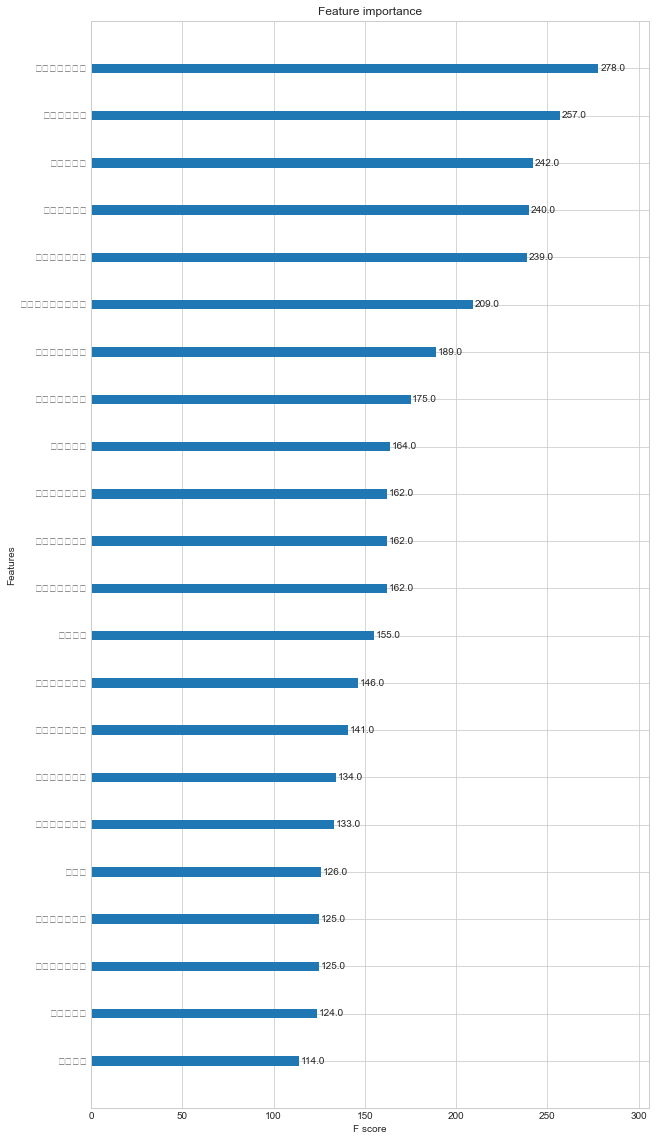

In [16]:
fig, ax=plt.subplots(figsize=(10,20))
plot_importance(xgb_model,ax=ax)